# Accident Detection


### Use LR/KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on the State of California. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.



### Step 1. Import libraries

In [ ]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

### Step 2. Import the dataset

In [ ]:
# Import the data
df = pd.read_csv('/content/Book1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     5000 non-null   object 
 1   Source                 5000 non-null   object 
 2   Severity               5000 non-null   int64  
 3   Start_Time             5000 non-null   object 
 4   End_Time               5000 non-null   object 
 5   Start_Lat              5000 non-null   float64
 6   Start_Lng              5000 non-null   float64
 7   End_Lat                0 non-null      float64
 8   End_Lng                0 non-null      float64
 9   Distance(mi)           5000 non-null   float64
 10  Description            5000 non-null   object 
 11  Street                 5000 non-null   object 
 12  City                   5000 non-null   object 
 13  County                 5000 non-null   object 
 14  State                  5000 non-null   object 
 15  Zipc

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [ ]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     5000 non-null   object        
 1   Source                 5000 non-null   object        
 2   Severity               5000 non-null   int64         
 3   Start_Time             5000 non-null   datetime64[ns]
 4   End_Time               5000 non-null   datetime64[ns]
 5   Start_Lat              5000 non-null   float64       
 6   Start_Lng              5000 non-null   float64       
 7   End_Lat                0 non-null      float64       
 8   End_Lng                0 non-null      float64       
 9   Distance(mi)           5000 non-null   float64       
 10  Description            5000 non-null   object        
 11  Street                 5000 non-null   object        
 12  City                   5000 non-null   object        
 13  Cou

### Step 4. Deal with outliers

#### A. Drop rows with negative time_duration

In [ ]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

128    -423288.0
1851   -253395.0
2873   -213030.0
Name: Time_Duration(min), dtype: float64

In [ ]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4997 entries, 0 to 4999
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     4997 non-null   object        
 1   Source                 4997 non-null   object        
 2   Severity               4997 non-null   float64       
 3   Start_Time             4997 non-null   datetime64[ns]
 4   End_Time               4997 non-null   datetime64[ns]
 5   Start_Lat              4997 non-null   float64       
 6   Start_Lng              4997 non-null   float64       
 7   End_Lat                0 non-null      float64       
 8   End_Lng                0 non-null      float64       
 9   Distance(mi)           4997 non-null   float64       
 10  Description            4997 non-null   object        
 11  Street                 4997 non-null   object        
 12  City                   4997 non-null   object        
 13  Cou

In [ ]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

### Step 4. Deal with outliers

#### B. Fill outliers with median values

In [ ]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4997 entries, 0 to 4999
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     4976 non-null   object        
 1   Source                 4976 non-null   object        
 2   Severity               4976 non-null   float64       
 3   Start_Time             4976 non-null   datetime64[ns]
 4   End_Time               4976 non-null   datetime64[ns]
 5   Start_Lat              4976 non-null   float64       
 6   Start_Lng              4976 non-null   float64       
 7   End_Lat                0 non-null      float64       
 8   End_Lng                0 non-null      float64       
 9   Distance(mi)           4976 non-null   float64       
 10  Description            4976 non-null   object        
 11  Street                 4976 non-null   object        
 12  City                   4976 non-null   object        
 13  Cou

In [ ]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 871.0 minutes or 15 hours or 1 days; Min to clear an accident td: 30.0 minutes.


### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [ ]:
# Select the columns you want to include in the factor analysis
feature_lst = ['ID','Source', 'Severity', 'Start_Lng', 'Start_Lat', 'Distance(mi)', 'City', 'County', 'State', 'Timezone',
               'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
               'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
               'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Hour', 'Weekday',
               'Time_Duration(min)']

In [ ]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4997 entries, 0 to 4999
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  4976 non-null   object 
 1   Source              4976 non-null   object 
 2   Severity            4976 non-null   float64
 3   Start_Lng           4976 non-null   float64
 4   Start_Lat           4976 non-null   float64
 5   Distance(mi)        4976 non-null   float64
 6   City                4976 non-null   object 
 7   County              4976 non-null   object 
 8   State               4976 non-null   object 
 9   Timezone            4976 non-null   object 
 10  Temperature(F)      4954 non-null   float64
 11  Humidity(%)         4954 non-null   float64
 12  Pressure(in)        4956 non-null   float64
 13  Visibility(mi)      4934 non-null   float64
 14  Wind_Direction      4957 non-null   object 
 15  Weather_Condition   4940 non-null   object 
 16  Amenit

### Step 6. Drop rows with missing values

In [ ]:
# Check missing values
df_sel.isnull().mean()

ID                    0.004203
Source                0.004203
Severity              0.004203
Start_Lng             0.004203
Start_Lat             0.004203
Distance(mi)          0.004203
City                  0.004203
County                0.004203
State                 0.004203
Timezone              0.004203
Temperature(F)        0.008605
Humidity(%)           0.008605
Pressure(in)          0.008205
Visibility(mi)        0.012608
Wind_Direction        0.008005
Weather_Condition     0.011407
Amenity               0.004203
Bump                  0.004203
Crossing              0.004203
Give_Way              0.004203
Junction              0.004203
No_Exit               0.004203
Railway               0.004203
Roundabout            0.004203
Station               0.004203
Stop                  0.004203
Traffic_Calming       0.004203
Traffic_Signal        0.004203
Turning_Loop          0.004203
Sunrise_Sunset        0.004203
Hour                  0.004203
Weekday               0.004203
Time_Dur

In [ ]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(4916, 33)

### Step 7. Select the state of interest: CA - CALIFORNIA
     

Due to the limitation of personal laptop, the whole US dataset is too big to handle

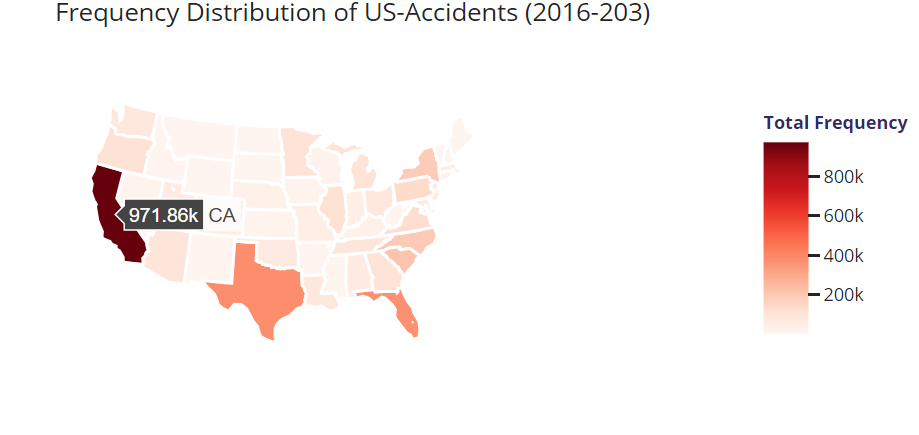

In [ ]:
# Define lists of states, colors, linestyles, month order, day_order, and hour_order
# For this notebook, we will focus on the following three states: DE, FL, & CA
state_lst=['CA']
state_lst_full=['California']

# We will focus on accident severities 2, 3 & 4
severity_lst=[2,3,4]

# Set a list of colors, markers and linestyles for plotting
color_lst=['r','b','k']
marker_lst=['D','o','*']
linestyle_lst=['dashed','dashdot','solid']

# Set a list of month, weekday, hour for reindex purpose and time_duraction to clear the accident
month_lst = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
weekday_lst = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_lst_full = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour_lst= np.arange(24)
td='Time_Duration(min)'

In [ ]:
df = df[df.State.isin(state_lst)]
df.head()

ID   Source  Severity          Start_Time            End_Time  \
728  A-729  Source2       3.0 2016-06-21 10:34:00 2016-06-21 11:04:00   
729  A-730  Source2       3.0 2016-06-21 10:30:00 2016-06-21 11:16:00   
730  A-731  Source2       2.0 2016-06-21 10:49:00 2016-06-21 11:19:00   
731  A-732  Source2       3.0 2016-06-21 10:41:00 2016-06-21 11:11:00   
732  A-733  Source2       2.0 2016-06-21 10:16:00 2016-06-21 11:04:00   

     Start_Lat   Start_Lng  End_Lat  End_Lng  Distance(mi)  \
728  38.085300 -122.233017      NaN      NaN           0.0   
729  37.631813 -122.084167      NaN      NaN           0.0   
730  37.896564 -122.070717      NaN      NaN           0.0   
731  37.334255 -122.032471      NaN      NaN           0.0   
732  37.250729 -121.910713      NaN      NaN           0.0   

                                           Description               Street  \
728  Right hand shoulder blocked due to accident on...          Magazine St   
729  Accident on I-880 Northbound at Exit 26 Tennys...              I-880 N   
730  Right lane blocked due to accident on CA-24 We...              I-680 N   
731  #4 &amp; HOV lane blocked due to accident on I...       N De Anza Blvd   
732  Right hand shoulder blocked due to accident on...  Norman Y Mineta Hwy   

             City        County State Zipcode Country    Timezone  \
728       Vallejo        Solano    CA   94591      US  US/Pacific   
729       Hayward       Alameda    CA   94544      US  US/Pacific   
730  Walnut Creek  Contra Costa    CA   94595      US  US/Pacific   
731     Cupertino   Santa Clara    CA   95014      US  US/Pacific   
732      San Jose   Santa Clara    CA   95118      US  US/Pacific   

    Airport_Code Weather_Timestamp  Temperature(F)  Wind_Chill(F)  \
728         KAPC  21-06-2016 10:54            75.0            NaN   
729         KHWD  21-06-2016 10:54            75.0            NaN   
730         KCCR  21-06-2016 10:53            82.9            NaN   
731         KNUQ  21-06-2016 10:56            75.9            NaN   
732         KRHV  21-06-2016 09:50            75.2            NaN   

     Humidity(%)  Pressure(in)  Visibility(mi) Wind_Direction  \
728         48.0         30.00            10.0       Variable   
729         48.0         30.06            10.0            WSW   
730         31.0         29.97            10.0            NNW   
731         48.0         30.04            10.0            NNE   
732         41.0         30.06            10.0       Variable   

     Wind_Speed(mph)  Precipitation(in) Weather_Condition Amenity   Bump  \
728              5.8                NaN             Clear   False  False   
729              4.6                NaN             Clear   False  False   
730              4.6                NaN             Clear   False  False   
731              4.6                NaN             Clear   False  False   
732              5.8                NaN             Clear   False  False   

    Crossing Give_Way Junction No_Exit Railway Roundabout Station   Stop  \
728    False    False    False   False   False      False   False  False   
729    False    False    False   False   False      False   False  False   
730    False    False    False   False   False      False   False  False   
731    False    False    False   False   False      False   False  False   
732    False    False    False   False   False      False   False  False   

    Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset Civil_Twilight  \
728           False          False        False            Day            Day   
729           False          False        False            Day            Day   
730           False          False        False            Day            Day   
731           False          False        False            Day            Day   
732           False          False        False            Day            Day   

    Nautical_Twilight Astronomical_Twilight    Year Month   Day  Hour Weekday  \
728               

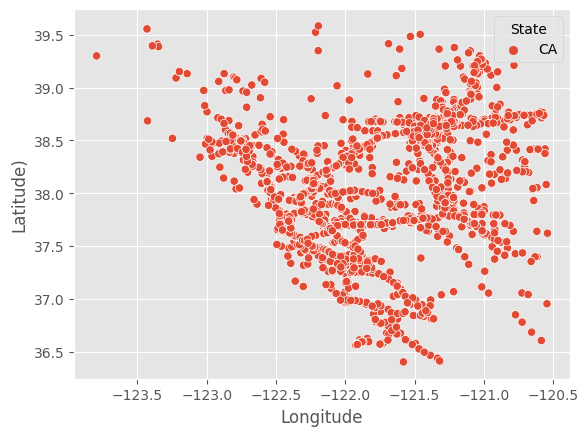

In [ ]:
# Visualization: map of accidents by state
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df, hue='State')
plt.xlabel('Longitude')
plt.ylabel('Latitude)')
plt.show()

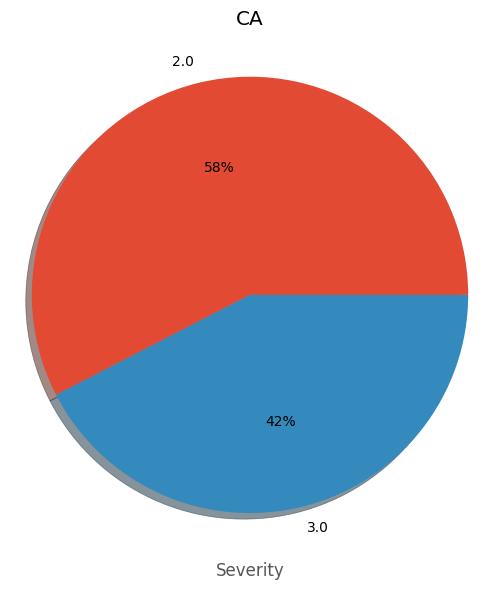

In [ ]:
# The severity of accidents for each state
feature='Severity'

# Set the size of the figure
fig= plt.figure(figsize=(15,6))

# Cutoff percentage for display
pct_cutoff=0

# Define autopct: only display the value if the percentage is greater than the predefined cutoff value
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''


# Run a for loop for each state
for i,state in enumerate(state_lst):

    # Set a sub plot
    plt.subplot(1, 3, 1+i)
    # Slice the dataframe for the specific state and feature
    df_temp=df[df['State']==state][feature].value_counts(normalize=True).round(2)

    # Define lables to go with the pie plot
    labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)]

    # Generate the pie plot
    plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)

    # Set axis,label and title
    plt.axis('equal')
    plt.xlabel(feature)
    plt.title(state)

plt.tight_layout()
plt.show()

In [ ]:
# Set state
state='CA'

# Select the state of Pennsylvania
df_state=df_sel.loc[df_sel.State==state]
df_state.drop('State',axis=1, inplace=True)
df_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4192 entries, 728 to 4999
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  4192 non-null   object 
 1   Source              4192 non-null   object 
 2   Severity            4192 non-null   float64
 3   Start_Lng           4192 non-null   float64
 4   Start_Lat           4192 non-null   float64
 5   Distance(mi)        4192 non-null   float64
 6   City                4192 non-null   object 
 7   County              4192 non-null   object 
 8   Timezone            4192 non-null   object 
 9   Temperature(F)      4192 non-null   float64
 10  Humidity(%)         4192 non-null   float64
 11  Pressure(in)        4192 non-null   float64
 12  Visibility(mi)      4192 non-null   float64
 13  Wind_Direction      4192 non-null   object 
 14  Weather_Condition   4192 non-null   object 
 15  Amenity             4192 non-null   object 
 16  Bump

<ipython-input-17-d0dddba7d7cb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_state.drop('State',axis=1, inplace=True)


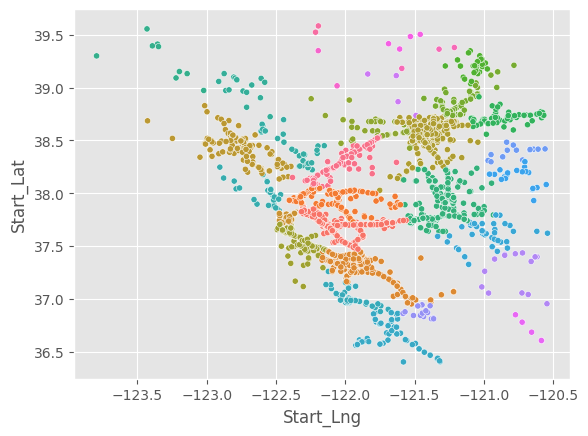

In [ ]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

### Step 8. Deal with categorical data: pd.get_dummies()


In [ ]:
# Generate dummies for categorical data
#assign numerical value to levels of categorical variables
df_state_dummy = pd.get_dummies(df_state,drop_first=True)

# Export data
df_state_dummy.to_csv('./US_Accidents_{}_dummy.csv'.format(state),index=False)

df_state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4192 entries, 728 to 4999
Columns: 4539 entries, Severity to Weekday_Wed
dtypes: float64(10), uint8(4529)
memory usage: 18.5 MB


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [ ]:
# Assign the data
df=df_state_dummy


# Set the target for the prediction
target='Severity'



# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [ ]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Weighted Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm A. Logistic regression              

In [ ]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.745.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### KNN with 6 neighors

In [ ]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.598.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.598.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors
   It took too much time, skip this part.

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm C. Decision Tree                 

In [ ]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.831.
[Decision Tree -- gini] accuracy_score: 0.828.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=100                 

In [ ]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Randon forest algorithm] accuracy_score: 0.840.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Visualize important features      

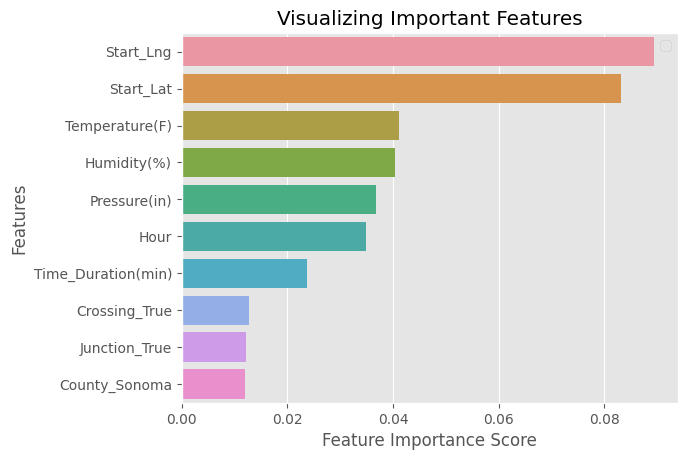

In [ ]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Start_Lng              0.089438
Start_Lat              0.083206
Temperature(F)         0.041097
Humidity(%)            0.040374
Pressure(in)           0.036706
Hour                   0.034966
Time_Duration(min)     0.023713
Crossing_True          0.012770
Junction_True          0.012180
County_Sonoma          0.012057
Traffic_Signal_True    0.011917
City_Pleasanton        0.009967
Stop_True              0.009494
City_Oakland           0.008822
County_Solano          0.008741
Visibility(mi)         0.008667
Weekday_Thu            0.008215
County_Sacramento      0.008207
County_Santa Clara     0.007724
Weekday_Wed            0.007569
dtype: float64

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Select the top important features, set the threshold      

In [ ]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
Temperature(F)
Humidity(%)
Pressure(in)
Hour


In [ ]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [ ]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.840.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.828.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Plot the accuracy score versus algorithm

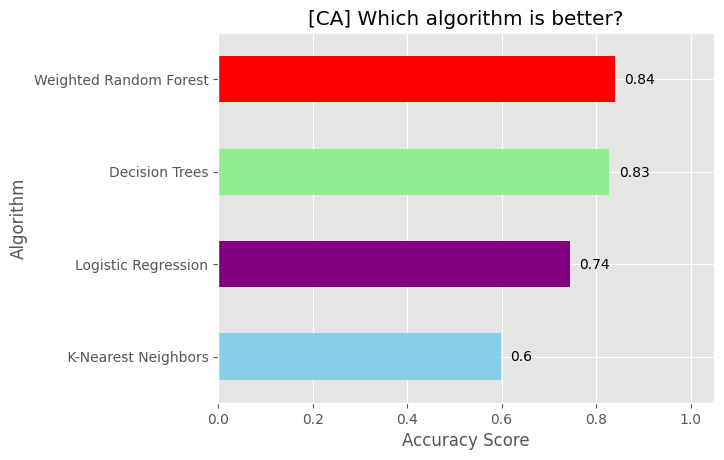

In [ ]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

colors = ['skyblue', 'purple', 'lightgreen', 'red']

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color=colors)

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.05)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}] Which algorithm is better?'.format(state))

plt.show()